# Decision Trees

Decision trees are one of the most intuitive and interpretable machine learning algorithms, making them excellent tools for both classification and regression tasks.

## What is a Decision Tree?

A decision tree is a flowchart-like structure where:
- Each **internal node** represents a "test" on an attribute/feature (e.g., whether a car's horsepower is larger than 200)
- Each **branch** represents the outcome of that test
- Each **leaf node** represents a final decision or prediction (class label for classification, value for regression)
- The **paths from root to leaf** represent the decision rules learned from the data

## Key Advantages

1. **Interpretability**: Easy to understand and visualize, even for non-technical stakeholders
2. **No feature scaling required**: Works well with features on different scales
3. **Handles both numerical and categorical data**: Flexible input requirements
5. **Feature interactions**: Automatically captures interactions between features

## Key Disadvantages

The biggest disadvantage of decision trees is that they are prone to overfitting.
A deep decision tree can fit the training data extremely well, by effectively memorizing the training data.
However, this is the trademark of overfitting, and we need to use techniques like cross-validation 
to evaluate the generalization performance of the model.

In [2]:
# Standard imports for data manipulation and visualization
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure seaborn for better-looking plots
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

## Loss Functions for Classification

Decision tree algorithms need a way to determine the quality of a split. They use criteria or measures (loss functions) to evaluate different potential splits and choose the one that best separates the classes.

### Three Common Split Criteria

1. **Classification Error Rate**: 
   - Measures the fraction of misclassified samples. 
   - Formula: $E = 1 - \max_i(p_i)$ where $p_i$ is the proportion of class $i$
   - Simple but not sensitive enough to make good splits.

2. **Gini Index (Gini Impurity)**: 
   - Measures the probability of incorrectly classifying a randomly chosen element.
   - Formula: $G = \sum_{i=1}^{C} p_i(1-p_i) = 1 - \sum_{i=1}^{C} p_i^2$
   - Lower values indicate purer nodes (better splits)

3. **Entropy (Information Gain)**: 
   - Measures the level of impurity or uncertainty in the data. Based on information theory.
   - Formula: $H = -\sum_{i=1}^{C} p_i \log_2(p_i)$
   - The split that provides the highest information gain (reduction in entropy) is chosen

For binary classification, we can visualize how these metrics vary with the class ratio: 

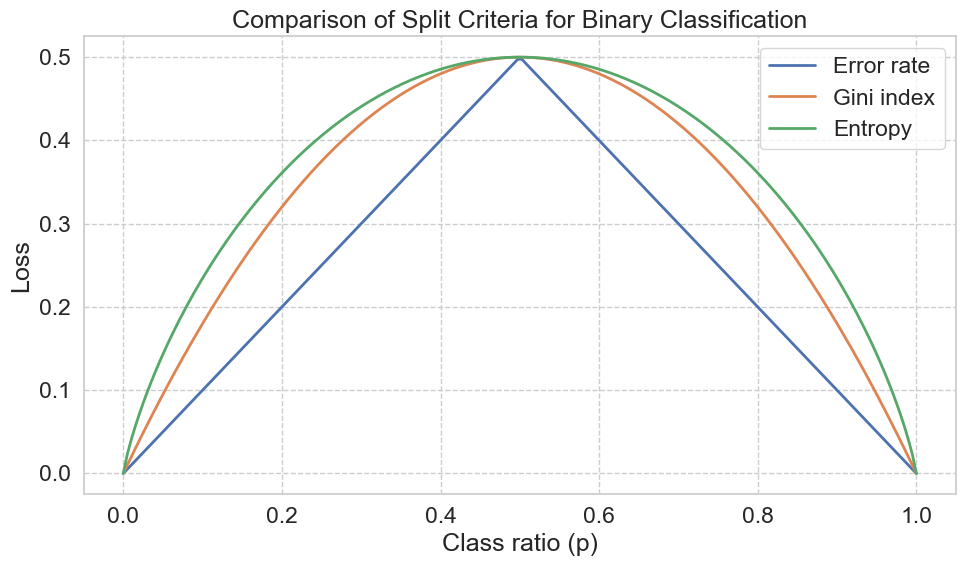

In [6]:
def error_rate(p: float):
    """Calculates classification error rate for a given binary class ratio.

    For binary classification, error rate is the minimum of p and 1-p,
    representing the fraction of misclassified samples if we predict
    the majority class.
    """
    return p if p < 0.5 else 1 - p

def gini_index(p: float):
    """Calculates Gini index for a given binary class ratio.

    Gini index measures impurity. For binary classification:
    G = 2 * p * (1-p), where p is the proportion of one class.
    It reaches maximum (0.5) when classes are perfectly balanced (p=0.5)
    and minimum (0) when the node is pure (p=0 or p=1).
    """
    return 2 * p * (1 - p)

def entropy(p: float):
    """Calculates entropy for a given binary class ratio, normalized by ln(2).

    Entropy measures the amount of information or uncertainty.
    For binary classification: H = -p*log2(p) - (1-p)*log2(1-p).
    We add a small epsilon (1e-16) to avoid log(0).
    The normalization ensures values are comparable to Gini index.
    """
    scale = 0.5 / np.log(2)
    return -(p * np.log(p + 1e-16) + (1 - p) * np.log(1 - p + 1e-16)) * scale

# Generate p values from 0 to 1 to visualize the loss functions
p = np.linspace(start=0, stop=1, num=200)

# Create comparison plot of the three loss functions
plt.figure(figsize=(10, 6))
sns.lineplot(x=p, y=[error_rate(x) for x in p], label="Error rate", linewidth=2)
sns.lineplot(x=p, y=[gini_index(x) for x in p], label="Gini index", linewidth=2)
sns.lineplot(x=p, y=[entropy(x) for x in p], label="Entropy", linewidth=2)

plt.ylabel("Loss")
plt.xlabel("Class ratio (p)")
plt.title("Comparison of Split Criteria for Binary Classification")
plt.tight_layout()
plt.show()

# Note: All three functions reach their maximum at p=0.5 (balanced classes)
# and minimum at p=0 or p=1 (pure nodes). Gini and Entropy are more sensitive
# to changes in class distribution, making them preferred for tree building.

## Binary Classification Example

Now let's apply decision trees to a real-world problem. We'll use the same **Breast Cancer Wisconsin dataset**, 
which we have used in the previous lectures.

In [7]:
# Load the breast cancer dataset from GitHub
cancer = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/breast_cancer.csv")

# Create a binary label: 0 for Benign (B), 1 for Malignant (M)
cancer["label"] = cancer["diagnosis"].apply(lambda x: 0 if x == "B" else 1)

# Display the first few rows to understand the data structure
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_mean,...,texture_extreme,perimeter_extreme,area_extreme,smoothness_extreme,compactness_extreme,concavity_extreme,concave_extreme,symmetry_extreme,fractal_extreme,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [8]:
# Import the decision tree module from scikit-learn
from sklearn import tree

# Create a decision tree classifier with specific hyperparameters
dt_model = tree.DecisionTreeClassifier(
    criterion="gini",  # Use Gini impurity as the split criterion
    max_depth=3,  # Limit tree depth to 3 levels to prevent overfitting
)

# Define all 30 features from the breast cancer dataset
# These are organized into three groups: mean, standard error (se), and extreme values
features = [
    # Mean values of cell nucleus measurements
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave_mean",
    "symmetry_mean",
    "fractal_mean",
    # Standard errors of the measurements
    "radius_se",
    "texture_se",
    "perimeter_se",
    "area_se",
    "smoothness_se",
    "compactness_se",
    "concavity_se",
    "concave_se",
    "symmetry_se",
    "fractal_se",
    # Worst (extreme) values of the measurements
    "radius_extreme",
    "texture_extreme",
    "perimeter_extreme",
    "area_extreme",
    "smoothness_extreme",
    "compactness_extreme",
    "concavity_extreme",
    "concave_extreme",
    "symmetry_extreme",
    "fractal_extreme",
]

# Define the target variable (label)
label = "label"

# Train the decision tree on the entire dataset
# Note: In practice, we should split data into train/test sets (we'll do this later)
dt_model.fit(X=cancer[features], y=cancer[label])

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [9]:
# Import graphviz for tree visualization
import graphviz

# Export the decision tree to DOT format for visualization
dot_data = tree.export_graphviz(
    decision_tree=dt_model,  # The trained decision tree model
    out_file=None,  # Return as string instead of writing to file
    feature_names=features,  # Use actual feature names instead of generic X[0], X[1]
    class_names=["Benign", "Malignant"],  # Label the classes meaningfully
    filled=True,  # Color nodes by class majority
    rounded=True,  # Use rounded boxes for better aesthetics
    special_characters=True,  # Allow special characters in labels
    max_depth=2,  # Only show first 2 levels for readability
)

# Create a graphviz object from the DOT data
graph = graphviz.Source(dot_data)

# Save the tree visualization to a file (optional)
graph.render("cancer_tree")

# Display the tree in the notebook
graph

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Advanced Topics

Now that we've built a basic decision tree, let's explore more advanced concepts including:
1. **Model Evaluation**: Assessing performance using proper train/test splits
2. **Overfitting vs. Underfitting**: Understanding the impact of tree depth
3. **Feature Importance**: Identifying which features matter most
4. **Comparison with Other Models**: How does the decision tree compare to logistic regression?
5. **Hyperparameter Tuning**: Exploring key parameters that control tree complexity


### 1. Model Evaluation with Train/Test Split

Previously, we trained on the entire dataset, which doesn't give us a fair assessment of how the model generalizes to new data. Let's properly split the data and evaluate performance.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training (80%) and testing (20%) sets
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    cancer[features],
    cancer[label],
    test_size=0.2,
    random_state=42,
    stratify=cancer[label]  # Maintain class distribution in both sets
)

# Train a new decision tree on the training data
dt_model_eval = tree.DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    random_state=42
)
dt_model_eval.fit(X_train, y_train)

# Make predictions on both training and test sets
y_train_pred = dt_model_eval.predict(X_train)
y_test_pred = dt_model_eval.predict(X_test)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Difference (Train - Test): {train_accuracy - test_accuracy:.4f}")
print("\n" + "="*60)
print("Classification Report (Test Set):")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=["Benign", "Malignant"]))


In [ ]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,           # Show numbers in cells
    fmt="d",              # Display as integers
    cmap="Blues",         # Color scheme
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"]
)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix - Decision Tree (max_depth=3)")
plt.tight_layout()
plt.show()

# Explain the confusion matrix components
print("Confusion Matrix Interpretation:")
print(f"  True Negatives (TN):  {cm[0, 0]} - Correctly predicted Benign")
print(f"  False Positives (FP): {cm[0, 1]} - Incorrectly predicted Malignant (Type I error)")
print(f"  False Negatives (FN): {cm[1, 0]} - Incorrectly predicted Benign (Type II error)")
print(f"  True Positives (TP):  {cm[1, 1]} - Correctly predicted Malignant")


### 2. Overfitting vs. Underfitting: The Role of Tree Depth

One of the most important hyperparameters in decision trees is `max_depth`, which controls how deep the tree can grow. Let's explore how this affects model performance:

- **Shallow trees (small max_depth)**: May underfit, missing important patterns
- **Deep trees (large max_depth)**: May overfit, memorizing training data instead of learning general patterns

We'll train multiple trees with different depths and compare their performance.


In [ ]:
# Test a range of max_depth values
max_depths = range(1, 21)  # Test depths from 1 to 20
train_scores = []
test_scores = []

# Train a model for each depth and record performance
for depth in max_depths:
    # Create and train the model
    dt = tree.DecisionTreeClassifier(
        criterion="gini",
        max_depth=depth,
        random_state=42
    )
    dt.fit(X_train, y_train)

    # Calculate and store accuracies
    train_scores.append(accuracy_score(y_train, dt.predict(X_train)))
    test_scores.append(accuracy_score(y_test, dt.predict(X_test)))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_scores, marker="o", label="Training Accuracy", linewidth=2)
plt.plot(max_depths, test_scores, marker="s", label="Test Accuracy", linewidth=2)
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Accuracy")
plt.title("Model Performance vs. Tree Depth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find the optimal depth
optimal_depth = max_depths[np.argmax(test_scores)]
print(f"Optimal max_depth based on test accuracy: {optimal_depth}")
print(f"Test accuracy at optimal depth: {max(test_scores):.4f}")
print(f"\nObservations:")
print(f"  - Training accuracy increases with depth (eventually reaches 1.0)")
print(f"  - Test accuracy peaks around depth {optimal_depth}, then may decrease")
print(f"  - The gap between train and test accuracy indicates overfitting")


### 3. Feature Importance Analysis

One of the great advantages of decision trees is that they naturally provide feature importance scores. These scores tell us which features were most useful in making predictions.

**How it works**: Features used in splits near the root of the tree (which separate large groups of samples) are considered more important than features used in splits near the leaves.


In [ ]:
# Extract feature importances from our trained model
feature_importances = dt_model_eval.feature_importances_

# Create a DataFrame for easier manipulation and visualization
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)

# Display top 15 most important features
print("Top 15 Most Important Features:")
print("="*60)
print(importance_df.head(15).to_string(index=False))
print(f"\nNumber of features with zero importance: {(importance_df['Importance'] == 0).sum()}")

# Visualize the top 15 features
plt.figure(figsize=(12, 8))
top_n = 15
top_features = importance_df.head(top_n)
sns.barplot(
    data=top_features,
    y="Feature",
    x="Importance",
    palette="viridis"
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Most Important Features in Decision Tree")
plt.tight_layout()
plt.show()


### 4. Comparison with Logistic Regression

To put our decision tree's performance in context, let's compare it with a logistic regression model, which we studied earlier in the course. This comparison will help us understand when to use each algorithm.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Logistic regression typically benefits from feature scaling
# Decision trees do NOT require scaling, but we'll scale for fair comparison
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Calculate accuracies
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

# Get decision tree accuracies from our previous model
dt_train_acc = train_accuracy
dt_test_acc = test_accuracy

# Compare the models
comparison_df = pd.DataFrame({
    "Model": ["Decision Tree (depth=3)", "Logistic Regression"],
    "Training Accuracy": [dt_train_acc, lr_train_acc],
    "Test Accuracy": [dt_test_acc, lr_test_acc],
    "Overfitting Gap": [dt_train_acc - dt_test_acc, lr_train_acc - lr_test_acc]
})

print("Model Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))
print("\n")

# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Decision Tree confusion matrix
cm_dt = confusion_matrix(y_test, y_test_pred)
sns.heatmap(
    cm_dt,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
    ax=axes[0]
)
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
axes[0].set_title(f"Decision Tree\nTest Accuracy: {dt_test_acc:.4f}")

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, lr_test_pred)
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
    ax=axes[1]
)
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")
axes[1].set_title(f"Logistic Regression\nTest Accuracy: {lr_test_acc:.4f}")

plt.tight_layout()
plt.show()

print("Key Takeaways:")
print("  - Decision trees provide interpretable, rule-based decisions")
print("  - Logistic regression provides probabilistic predictions")
print("  - Performance can vary depending on the problem and data")
print("  - Decision trees don't require feature scaling")


### 5. Hyperparameters and Tree Pruning

Decision trees have several hyperparameters that control their complexity and help prevent overfitting. Understanding these is crucial for building effective models.

#### Key Hyperparameters

1. **max_depth**: Maximum depth of the tree
   - Controls how many questions the tree can ask in sequence
   - Deeper trees can capture more complex patterns but risk overfitting

2. **min_samples_split**: Minimum number of samples required to split an internal node
   - Higher values prevent creating splits based on very few samples
   - Helps prevent overfitting by avoiding too-specific rules

3. **min_samples_leaf**: Minimum number of samples required at a leaf node
   - Ensures each leaf represents a meaningful number of samples
   - Smooths the model and prevents overfitting

4. **max_features**: Number of features to consider when looking for the best split
   - Can speed up training and reduce overfitting
   - Common values: "sqrt" (square root of total features), "log2", or a specific number

5. **criterion**: Function to measure split quality
   - "gini" (default): Gini impurity
   - "entropy": Information gain

Let's experiment with these hyperparameters:


In [ ]:
# Compare different hyperparameter configurations
models_config = [
    {"name": "Default (unconstrained)", "params": {}},
    {"name": "Max depth = 3", "params": {"max_depth": 3}},
    {"name": "Min samples split = 20", "params": {"min_samples_split": 20}},
    {"name": "Min samples leaf = 10", "params": {"min_samples_leaf": 10}},
    {"name": "Max features = sqrt", "params": {"max_features": "sqrt"}},
    {"name": "Combined constraints", "params": {
        "max_depth": 5,
        "min_samples_split": 20,
        "min_samples_leaf": 5
    }},
]

results = []

# Train and evaluate each configuration
for config in models_config:
    # Create model with specified parameters
    model = tree.DecisionTreeClassifier(
        criterion="gini",
        random_state=42,
        **config["params"]  # Unpack the parameters
    )

    # Train and evaluate
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    # Store results
    results.append({
        "Configuration": config["name"],
        "Train Acc": train_acc,
        "Test Acc": test_acc,
        "Overfitting Gap": train_acc - test_acc,
        "Num Leaves": model.get_n_leaves(),
        "Tree Depth": model.get_depth()
    })

# Display results
results_df = pd.DataFrame(results)
print("Hyperparameter Comparison:")
print("="*90)
print(results_df.to_string(index=False))
print("\nKey Observations:")
print("  - Unconstrained trees often achieve perfect training accuracy but may overfit")
print("  - Constraints reduce overfitting at the cost of some training accuracy")
print("  - The goal is to maximize test accuracy, not training accuracy")
print("  - Different constraints affect tree size (num leaves and depth)")


## Summary and Best Practices

### When to Use Decision Trees

✅ **Good for:**
- Problems where interpretability is crucial
- Mixed feature types (numerical and categorical)
- Non-linear relationships
- Feature selection (through feature importance)
- Quick baseline models

❌ **Not ideal for:**
- High-dimensional sparse data (like text)
- Very smooth linear relationships (use linear models instead)
- Problems requiring very stable predictions
- Small datasets (prone to overfitting)

### Best Practices

1. **Always use train/test splits** to evaluate generalization performance
2. **Tune hyperparameters** (especially `max_depth`, `min_samples_split`, `min_samples_leaf`)
3. **Use cross-validation** for more robust performance estimates
4. **Consider ensemble methods** (Random Forests, Gradient Boosting) for better performance
5. **Check feature importance** to understand which features matter most
6. **Visualize the tree** (for small trees) to understand the learned rules
7. **Compare with simpler models** (like logistic regression) to ensure complexity is justified

### Extensions

- **Random Forests**: Ensembles of decision trees that reduce overfitting and improve stability
- **Gradient Boosting**: Sequential ensembles (XGBoost, LightGBM, CatBoost) that achieve state-of-the-art performance
- **Regression Trees**: Use decision trees for continuous target variables
- **Cost-sensitive learning**: Adjust for class imbalance or different misclassification costs
